# Rating Distribution Analysis for GAP (on Amazon)

In [1]:
#importing required packages
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import random
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#intializing the options object to be fed into webdriver parameters
chrome_options=Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [3]:
# Add a custom User-Agent
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
chrome_options.add_argument(f'user-agent={user_agent}')

In [4]:
'''
Adding the property to not let program close the browser window post execution
This comes quite handy while visualizing how browser content are changing during 
execution and what was the last state of browser
'''
chrome_options.add_experimental_option("detach", True)

In [5]:
#starting the chrome driver
driver=webdriver.Chrome(options=chrome_options)

In [6]:
#setting up the target website ot be scrapped
target='https://www.amazon.com/s?k=GAP+Clothing&ref=cs_503_search'

In [7]:
#getting the web page
driver.get(target)
#waiting for the page to load
time.sleep(random.uniform(2, 10))
#maximizing the browser window
driver.maximize_window()

In [8]:
# Store product data
product_data = {
    "Product Name": [],
    "Price": [],
    "Rating": [],
    "Review Count": []
}

In [9]:
page_number=1
while page_number<7:
    #selecting a product block
    products = driver.find_elements(By.XPATH, '//div[contains(@class, "s-main-slot")]/div[@data-component-type="s-search-result"]')
    # Iterate over the products and extract details
    for product in products:
        if product.find_element(By.XPATH,'.//h2[@class="a-size-mini s-line-clamp-1"]').text=='GAP':
            try:
                # Product Name
                product_name = product.find_element(By.XPATH,'.//span[@class="a-size-base-plus a-color-base a-text-normal"]').text
            except:
                product_name = 'N/A'

            try:
                # Price
                price = product.find_element(By.XPATH, './/span[@class="a-price-whole"]').text
                price_fraction = product.find_element(By.XPATH, './/span[@class="a-price-fraction"]').text
                full_price = f"{price}.{price_fraction}"
            except:
                full_price = 'N/A'

            try:
                # Rating
                rating = product.find_element(By.XPATH, './/span[@class="a-icon-alt"]').get_attribute('innerHTML').split()[0]
            except:
                rating = 'N/A'

            try:
                # Review Count
                review_count = product.find_element(By.XPATH, './/span[@class="a-size-base s-underline-text"]').text
            except:
                review_count = 'N/A'

            # Store the product details in the dictionary
            product_data["Product Name"].append(product_name)
            product_data["Price"].append(full_price)
            product_data["Rating"].append(rating)
            product_data["Review Count"].append(review_count)
        else:
            pass
    
    try:
        #incrementing the page number
        page_number+=1
        #wait till the next button appears and then locate it
        button = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, '//a[contains(@class, "s-pagination-next")]'))
        )
        # Click the "Next" button
        button.click()
        
        #waiting for the page to load
        time.sleep(10)
    except:
        print(page_number)
        print("No 'Next' button found. Ending the loop.")
        break


In [32]:
df = pd.DataFrame(product_data)

In [33]:
df.shape

(297, 4)

In [34]:
df.tail()

,Product Name,Price,Rating,Review Count
292,Boys and Girls' Kids Logo Crew Neck Sweatshirt,23.66,N/A,N/A
293,Baby-Girls Short Sleeve Logo T-shirt,11.38,4.8,149
294,Boys' Straight Taper Fit Jeans,28.74,N/A,N/A
295,Boys' V-Fall Nvlty Logo Po,34.99,N/A,N/A
296,Women's Gauze Big Shirt,36.93,4.5,12


In [35]:
# Convert 'Rating' and 'Review Count' columns to numeric, forcing errors to NaN for missing values
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Review Count'] = pd.to_numeric(df['Review Count'], errors='coerce')

## Plot for Top 10 Most Popular Items based on Review Count

In [40]:
top_popular_items.head(10)

,Product Name,Price,Rating,Review Count
33,Boys' Logo Hoodie Hooded Sweatshirt,N/A,4.6,826.0
0,Women's Logo Hoodie Hooded Full Zip Sweatshirt,24.99,4.7,803.0
4,Women's Logo Hoodie Hooded Full Zip Sweatshirt,29.99,4.7,803.0
59,Women's Logo Hoodie Hooded Full Zip Sweatshirt,24.99,4.7,803.0
103,Women's Logo Hoodie Hooded Full Zip Sweatshirt,N/A,4.7,803.0
254,Women's Logo Hoodie Hooded Full Zip Sweatshirt,29.99,4.7,803.0
107,Men's Stretch Pique Polo Shirt,17.99,4.5,716.0
32,Womens Fitted Cami,6.00,4.3,712.0
66,Women's 2-Pack Crewneck Favorite Tee T-Shirt,N/A,4.5,712.0
13,Men's Logo Hoodie Hooded Full Zip Sweatshirt,20.00,4.7,694.0


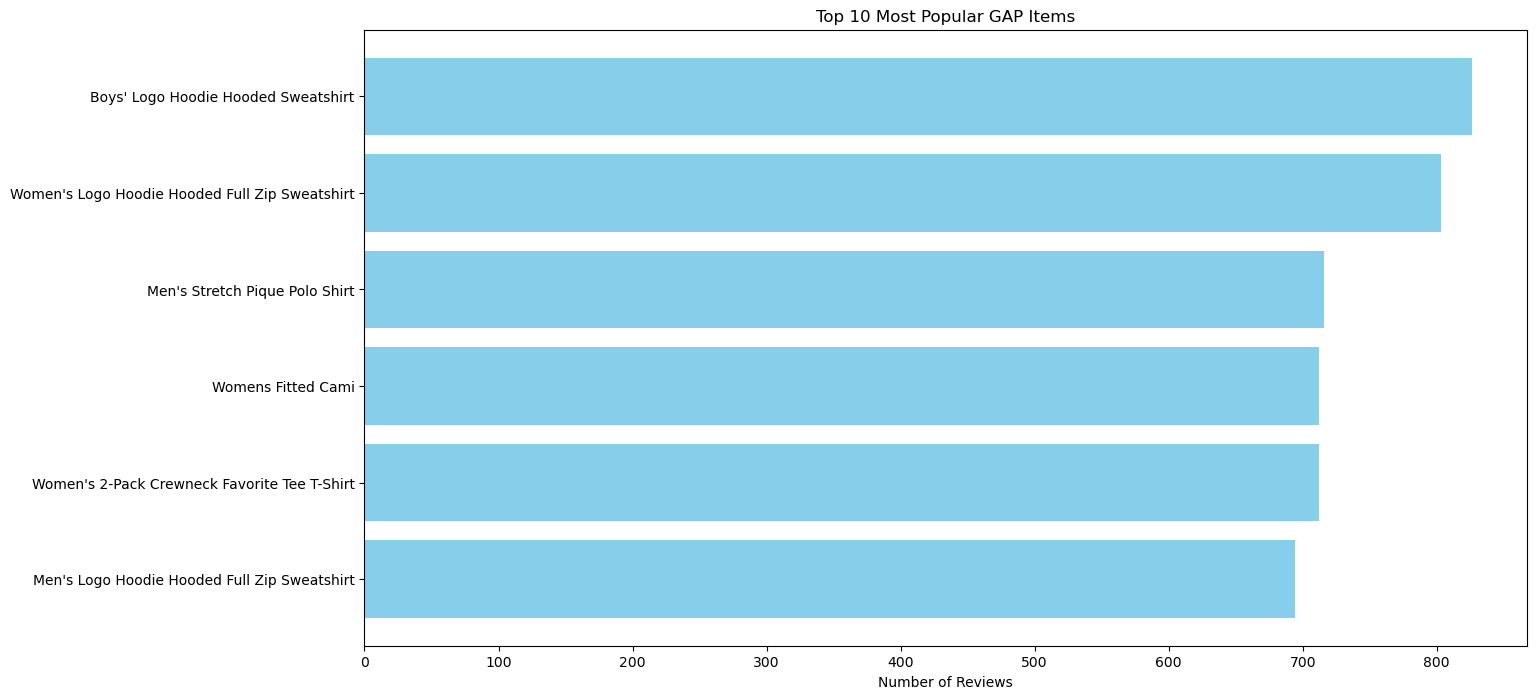

In [14]:
#visualization 1
#filtering by top review counts
top_popular_items = df.nlargest(10, 'Review Count')

plt.figure(figsize=(15, 8))
plt.barh(top_popular_items['Product Name'], top_popular_items['Review Count'], color='skyblue')
plt.xlabel('Number of Reviews')
plt.title('Top 10 Most Popular GAP Items')
plt.gca().invert_yaxis()  # Invert y-axis to show the most popular items on top
plt.show()

##  Distribution of Ratings

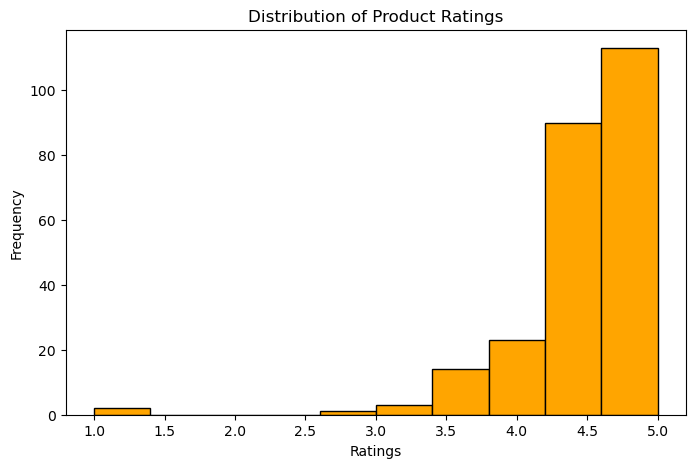

In [15]:
#visualization 2
plt.figure(figsize=(8, 5))
plt.hist(df['Rating'].dropna(), bins=10, color='orange', edgecolor='black')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Product Ratings')
plt.show()

## Items with Lowest Ratings (Badly Reviewed)

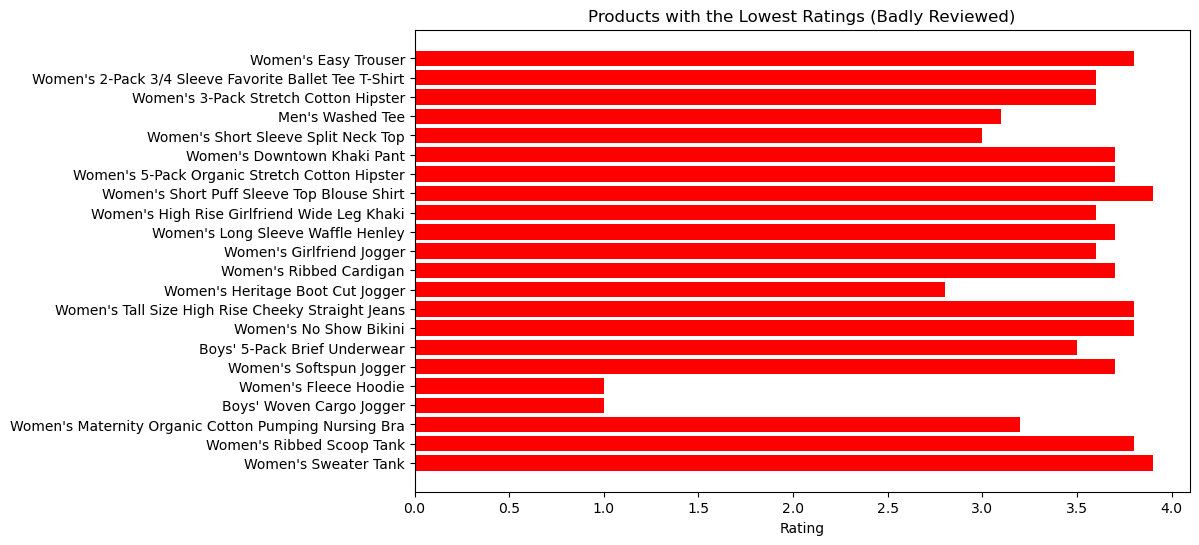

In [16]:
#visualization 3
# Assuming items with ratings below 4.0 are considered badly reviewed
badly_reviewed_items = df[df['Rating'] < 4.0]

plt.figure(figsize=(10, 6))
plt.barh(badly_reviewed_items['Product Name'], badly_reviewed_items['Rating'], color='red')
plt.xlabel('Rating')
plt.title('Products with the Lowest Ratings (Badly Reviewed)')
plt.gca().invert_yaxis()  # Invert y-axis to show the lowest ratings on top
plt.show()

## Elasticity Analysis (Review Count v/s Price, Ratings & Price v/s Ratings)

In [36]:
df.head(10)

,Product Name,Price,Rating,Review Count
0,Women's Logo Hoodie Hooded Full Zip Sweatshirt,24.99,4.7,803.0
1,Women's Logo Hoodie Hooded Full Zip Sweatshirt,29.99,4.7,NaN
2,Men's Logo Heritage Hoodie Hooded Full Zip Swe...,29.99,4.6,206.0
3,Women's Logo Hoodie Hooded Pull-on Sweatshirt,24.99,4.7,NaN
4,Women's Logo Hoodie Hooded Full Zip Sweatshirt,29.99,4.7,803.0
5,Women's Favorite Tank Top,6.99,4.3,NaN
6,Men's Everyday Soft Crewneck T-Shirt Tee,8.00,4.6,NaN
7,Women's Favorite Crewneck Tee T-Shirt,8.00,4.4,433.0
8,Boys' Logo Hoodie Hooded Full Zip Sweatshirt,14.00,4.0,593.0
9,Baby Girls' Playtime Favorites Logo Pullover H...,9.00,4.8,321.0


In [37]:
df.dtypes

Product Name     object
Price            object
Rating          float64
Review Count    float64
dtype: object

In [38]:
#changing the datatype of Price to float
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Data Cleaning - drop rows with missing values in relevant columns
df = df.dropna(subset=['Price', 'Review Count', 'Rating'])

In [39]:
df.head()

,Product Name,Price,Rating,Review Count
0,Women's Logo Hoodie Hooded Full Zip Sweatshirt,24.99,4.7,803.0
2,Men's Logo Heritage Hoodie Hooded Full Zip Swe...,29.99,4.6,206.0
4,Women's Logo Hoodie Hooded Full Zip Sweatshirt,29.99,4.7,803.0
7,Women's Favorite Crewneck Tee T-Shirt,8.00,4.4,433.0
8,Boys' Logo Hoodie Hooded Full Zip Sweatshirt,14.00,4.0,593.0


In [26]:
#Regression Model 1 - Review Count vs. Price
X1 = df[['Price']]
y1 = df['Review Count']

# Add constant (intercept) to the model
X1 = sm.add_constant(X1)

# Fit the regression model
model1 = sm.OLS(y1, X1).fit()

# Print the summary of the regression model
print("Model 1: Review Count vs Price and Ratings")
print(model1.summary())

Model 1: Review Count vs Price and Ratings
                            OLS Regression Results                            
Dep. Variable:           Review Count   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7276
Date:                Tue, 01 Oct 2024   Prob (F-statistic):              0.395
Time:                        18:16:07   Log-Likelihood:                -1411.9
No. Observations:                 211   AIC:                             2828.
Df Residuals:                     209   BIC:                             2835.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

### Insights from Elasticity Analysis in the Regression

From the regression output provided, we can extract the following insights related to the elasticity analysis:

1. **Model Overview**:  
   - The dependent variable is "Review Count," and the independent variable in the model is "Price."
   - This analysis aims to understand how changes in price affect the number of reviews a product receives.

2. **R-Squared and Adjusted R-Squared**:
   - **R-squared** is 0.003, indicating that only 0.3% of the variability in review count is explained by the price.
   - The **Adjusted R-squared** is -0.001, suggesting that the model does not fit the data well and adding price as an explanatory variable does not significantly improve the model's explanatory power.

3. **Coefficient of Price**:
   - The coefficient for "Price" is 1.4664, which suggests a positive relationship between price and review count. However, this relationship is not statistically significant (`P > |t|` = 0.395).
   - **Interpretation**: For a unit increase in price, the review count is expected to increase by approximately 1.47, holding all else constant. However, the lack of statistical significance means we cannot confidently say that changes in price truly affect review count.

4. **Statistical Significance**:
   - The **P-value** for the price coefficient (0.395) is much greater than common significance levels (0.05 or 0.01), indicating that the relationship between price and review count is not statistically significant.
   - The F-statistic's P-value (0.395) further confirms that the overall model is not statistically significant.

5. **Elasticity Analysis**:
   - Given the coefficient of 1.4664, a positive elasticity is suggested. This would mean that as the price increases, the review count might increase as well. However, since the relationship is statistically insignificant, this potential elasticity is weak and not reliable.
   - **Practical Insight**: The lack of significance implies that other factors, rather than price, likely play a more crucial role in driving the number of reviews a product receives.

6. **Constant (Intercept)**:
   - The intercept (133.2450) represents the estimated review count when the price is zero. This is more of a baseline value and does not carry much practical interpretation in the context of elasticity.

### Summary
The regression analysis suggests a very weak and statistically insignificant relationship between price and review count. Therefore, changes in price do not seem to meaningfully impact the number of reviews a product receives. This implies that price elasticity of reviews is not evident from this analysis, and other factors likely drive review behavior more significantly.

In [29]:
#Regression Model 2 - Review Count vs Ratings
X2 = df[['Rating']]
y2 = df['Review Count']

# Add constant (intercept) to the model
X2 = sm.add_constant(X2)

# Fit the regression model
model2 = sm.OLS(y2, X2).fit()

# Print the summary of the regression model
print("Model 2: Review Count (Demand) vs Ratings")
print(model2.summary())

Model 2: Review Count (Demand) vs Ratings
                            OLS Regression Results                            
Dep. Variable:           Review Count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.1213
Date:                Tue, 01 Oct 2024   Prob (F-statistic):              0.728
Time:                        18:19:04   Log-Likelihood:                -1412.2
No. Observations:                 211   AIC:                             2828.
Df Residuals:                     209   BIC:                             2835.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

### Insights from Elasticity Analysis in the Regression

From the regression output provided, we can derive the following insights related to the elasticity analysis:

1. **Model Overview**:  
   - The dependent variable is "Review Count," and the independent variable is "Rating."
   - This analysis seeks to explore how the ratings of products impact the number of reviews they receive.

2. **R-Squared and Adjusted R-Squared**:
   - **R-squared** is 0.001, indicating that only 0.1% of the variability in the review count is explained by the product's rating.
   - The **Adjusted R-squared** is -0.004, implying that the model does not fit the data well. Including "Rating" as an explanatory variable fails to improve the model's explanatory power.

3. **Coefficient of Rating**:
   - The coefficient for "Rating" is 8.8893, suggesting a positive relationship between the rating and review count. However, this relationship is **not statistically significant** (`P > |t|` = 0.728).
   - **Interpretation**: A one-unit increase in the rating is associated with an increase of approximately 8.89 in the review count, assuming all else remains constant. However, due to the lack of statistical significance, this relationship cannot be relied upon.

4. **Statistical Significance**:
   - The **P-value** for the rating coefficient (0.728) is much higher than common significance levels (0.05 or 0.01), indicating that the relationship between the rating and review count is not statistically significant.
   - The F-statistic's P-value (0.728) also supports that the overall model is not statistically significant.

5. **Elasticity Analysis**:
   - The positive coefficient of 8.8893 suggests potential positive elasticity, where an increase in rating might lead to a higher review count. However, since this relationship is statistically insignificant, we cannot confidently assert that changes in ratings drive changes in the number of reviews.
   - **Practical Insight**: This result indicates that factors other than ratings are likely more important in influencing the number of reviews a product receives.

6. **Constant (Intercept)**:
   - The intercept (123.1385) represents the estimated review count when the rating is zero. While this provides a baseline value, it is not meaningful in practical terms since ratings typically do not go down to zero.

### Summary
The regression analysis indicates a very weak and statistically insignificant relationship between product ratings and the number of reviews. This suggests that the elasticity of review count with respect to ratings is negligible, meaning that changes in product ratings do not appear to meaningfully affect the number of reviews. Other factors not included in this model are likely influencing the review count more significantly.

In [41]:
driver.close

<bound method WebDriver.close of <selenium.webdriver.chrome.webdriver.WebDriver (session="24a264141aae0dee7585a1025dc9e6d7")>>